# Step 1 Box plot  (distribution #comments/each post among different facebook fans pages)

In [ ]:
%matplotlib inline

import pyes
import json
import pandas as pd
import seaborn as sns

def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

# Step 2: Please assign several Facebook fan pages and parameters 

## (code-customerized by yourself is required!)


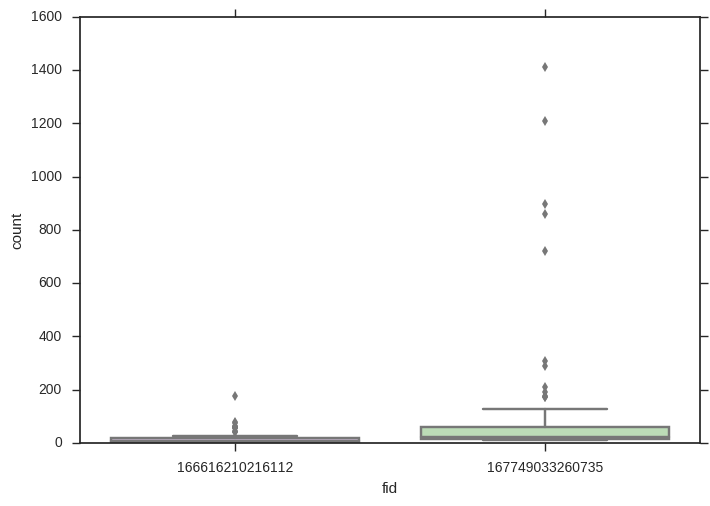

In [35]:
#assign the facebook fans page that you prefered
# fids=['139624776093433','1448357445384692','179080912217031']
fids=['167749033260735','166616210216112']
# nike adidas

#elasticsearch repository provided by this course
# host = '114.32.24.166:9200'
host = '140.118.175.209:9200'

#output box plot PNG figure
pngFilePath="output.png"

#outlier threshold you want to filter (if you give minus ONE, none of outlier is filtered.)
outlierFilter=2000

#obtain the result and save as "pngFilePath" given from you
boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

# Step 3: Box plot (#post per month for specified page)¶

In [36]:
import pyes
import json
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid,host,lowerbound,upperbound,pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')

    data=[]
    for r in result.aggs["month"]["buckets"]:
        for pid in r["pid"]["buckets"]:
            monthyear=datetime.datetime.strptime(r["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%Y/%m')
            data.append([pid["doc_count"],monthyear,pid["key"],r["key"]])

    df=pd.DataFrame(data,columns={'date','count','fid','pid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="date", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)

# Step 4: Please assign several Facebook fan pages and parameters
(code-customerized by yourself is required!)

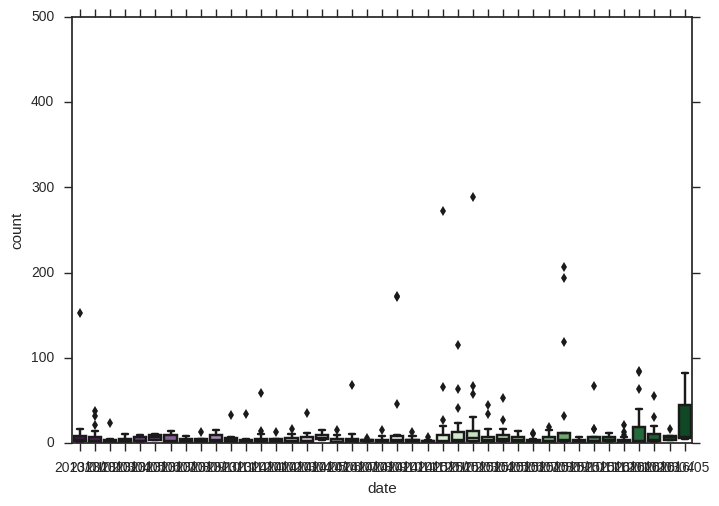

In [37]:
# host = '114.32.24.166:9200'
host = '140.118.175.209:9200'

lower_bound = 0
upper_bound = 500
fid="167749033260735"
pngFilePath="nike.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

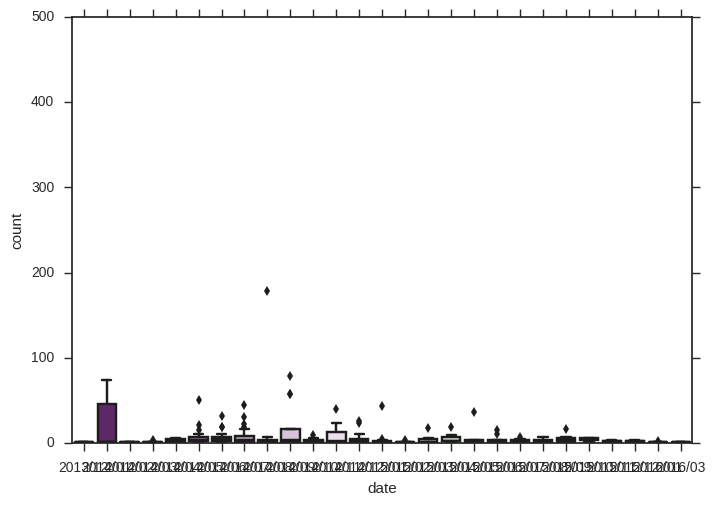

In [38]:
# host = '114.32.24.166:9200'
host = '140.118.175.209:9200'
lower_bound = 0
upper_bound = 500
fid="166616210216112"
pngFilePath="adidas.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

In [40]:
# host = '114.32.24.166:9200'
# host = '140.118.175.209:9200'
# lower_bound = 0
# upper_bound = 500
# fid="179080912217031"
# pngFilePath="output5.png"
# boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

# Step 5 Get User-Post frequence matrix
## input {es address, row name, column name, fans page ID}

In [41]:
import pyes
import json

def getUserPostFreqMatrix(es_address,row,column,fid):
    rc=200
    cc=200
    
    rowIndexList,colIndexList,matrix = [],[],[]
    conn=pyes.es.ES(es_address)
    tq = pyes.query.TermQuery(field="fid", value=fid)

    tagg = pyes.aggs.TermsAgg(row, field= r, sub_aggs=[]) 
    tagg1 = pyes.aggs.TermsAgg(column, field= c)  
    tagg.sub_aggs.append(tagg1) 

    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg)

    rs = conn.search(query=qsearch, indices='facebook_nested' ,type="comment" )
    
    rowcount=0
    colcount=0
    for user in rs.aggs[row]['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1

        for post in user[column]['buckets']:
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1

    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        if user["key"] in rowIndexList:
            for post in user[column]['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])]= float(post['doc_count'])
    
    
    return {"data":matrix,"col":colIndexList,"row":rowIndexList}

# Step 6: Please assign specified Facebook fan page and parameters

In [42]:
# es_address="114.32.24.166:9200"
es_address = '140.118.175.209:9200'
r="from.id"
c="fid_pid"
fid="166616210216112"
result = getUserPostFreqMatrix(es_address,r,c,fid)
# print result

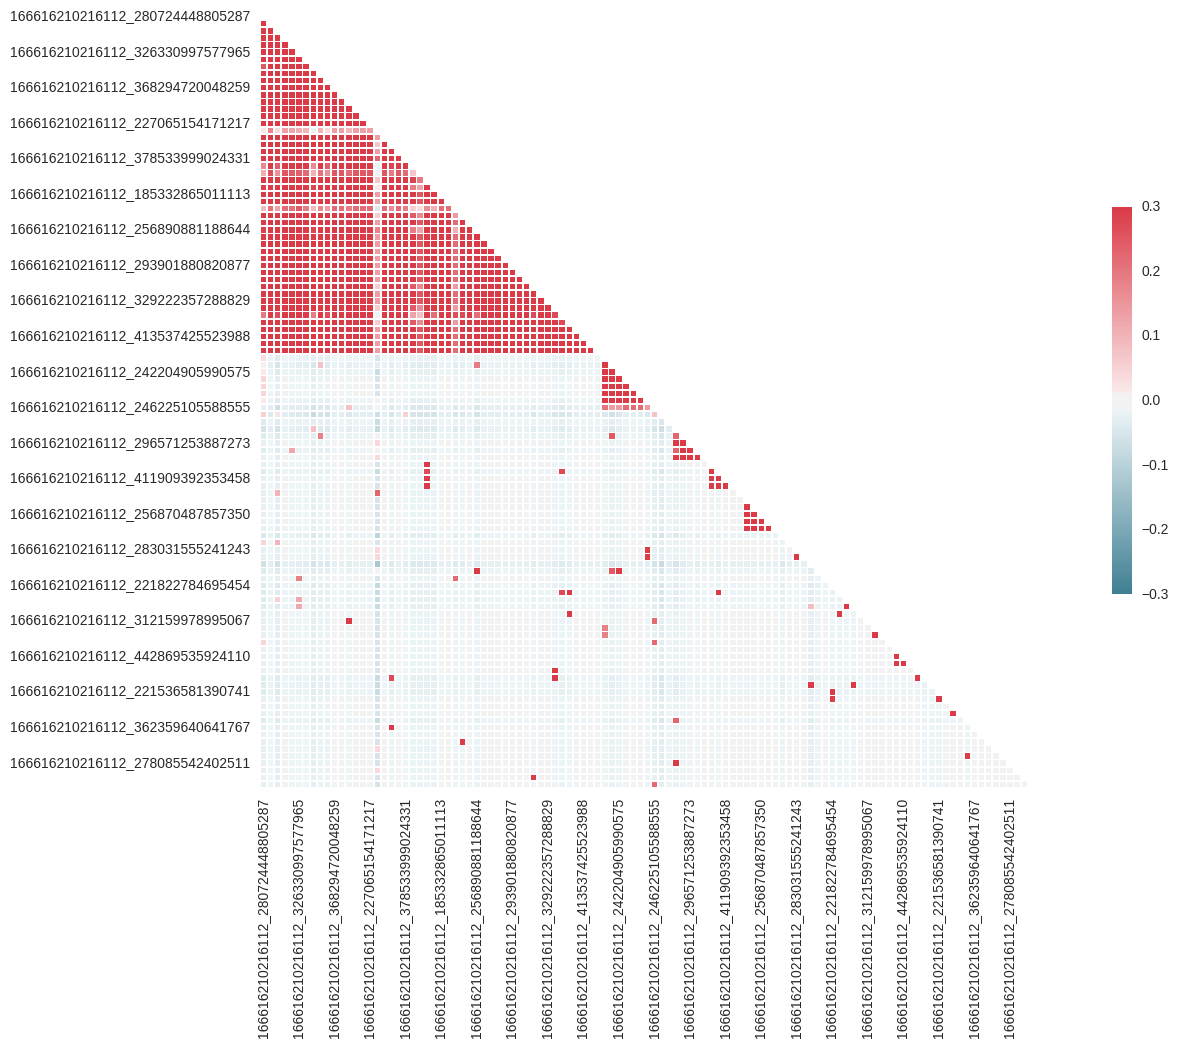

In [43]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [44]:
result["row"]

[u'166616210216112',
 u'10153464346398271',
 u'933915893328673',
 u'1072501809450766',
 u'1692454390969690',
 u'454589304727049',
 u'1097218533624753',
 u'1232826586733002',
 u'1562194787431966',
 u'962770150402931',
 u'10156364769555501',
 u'1063690396980519',
 u'828644317183812',
 u'846504048777076',
 u'1007692949253607',
 u'10205463351527053',
 u'10207139280174269',
 u'10207812866586832',
 u'1102336429789948',
 u'1160750650619468',
 u'1272758412741383',
 u'1296307960386713',
 u'547178515455390',
 u'582306311931959',
 u'588208897999121',
 u'683368621766919',
 u'894287700666720',
 u'897619363679343',
 u'939462689463536',
 u'970219446330172',
 u'1007114102679406',
 u'10153154755126205',
 u'10153847687053094',
 u'1018226118219094',
 u'10201256182042407',
 u'10205950801630459',
 u'1021286401262723',
 u'1038629772825520',
 u'1085613371458364',
 u'1117666404918442',
 u'1197781453575254',
 u'1252801621402905',
 u'1256772801005506',
 u'1282825015066921',
 u'147646098777133',
 u'3280669939842